In [1]:
import csv
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/result_data/papers/ai_paper_features_100k.csv")

In [ ]:
len(df)

91790

In [ ]:
# df.citation.describe()
np.percentile(df.citation.values, 95)

113.0

In [ ]:
author_num = [each.count('}') for each in df.authors.values]
np.percentile(author_num, 95)

10.0

In [ ]:
highly_cited = df[df["citation"] >= 113]
len(highly_cited)

4600

In [ ]:
many_coauthor = []
for index, row in df.iterrows():
  if row["authors"].count('}') >= 10:
    many_coauthor.append(row)
many_coauthor_df = pd.DataFrame(many_coauthor)
len(many_coauthor_df)

5615

In [ ]:
with open("/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/result_data/papers/100k_papers_task_method.jsonl") as f:
  papers = [json.loads(line) for line in f if line.strip()]

In [ ]:
female_first = 0
female_last = 0
male_first = 0
male_last = 0
female_dominate = 0
male_dominate = 0
female_dominate = 0
for index, row in many_coauthor_df.iterrows():
  female = 0
  male = 0
  genders = row["genders"]
  genders = genders.replace('[','')
  genders = genders.replace(']','')
  genders = genders.split(",")
  if genders[0].strip() == "'F'":
    female_first += 1
  elif genders[0].strip() == "'M'":
    male_first += 1
  if genders[-1].strip() == "'F'":
    female_last += 1
  elif genders[-1].strip() == "'M'":
    male_last += 1
  for gender in genders:
    if gender.strip() == "'F'":
      female += 1
    elif gender.strip() == "'M'":
      male += 1
  if female + male != 0 and male / (female + male) > 0.5:
    male_dominate += 1
  elif female + male != 0 and female / (female + male) > 0.5:
    female_dominate += 1

print(female_first)
print(male_first)
print(female_dominate)
print(male_dominate)
print(female_last)
print(male_last)

468
1147
601
2852
304
1093


In [ ]:
females = []
female_first_gsid = []
female_last_gsid = []
female_dominate_gsid = []
for index, row in df.iterrows():
  genders = row["genders"]
  genders = genders.replace('[','')
  genders = genders.replace(']','')
  genders = genders.split(",")
  male = 0
  female = 0
  # print(genders[0].strip())
  if genders[0].strip() == "'F'":
    females.append(row)
    female_first_gsid.append(row["gs_id"])
  if genders[-1].strip() == "'F'":
    female_last_gsid.append(row["gs_id"])
  for gender in genders:
    if gender.strip() == "'F'":
      female += 1
    elif gender.strip() == "'M'":
      male += 1
  if female + male != 0 and female / (female + male) > 0.5:
    female_dominate_gsid.append(row["gs_id"])
female_df = pd.DataFrame(females)

In [ ]:
males = []
male_first_gsid = []
for index, row in df.iterrows():
  genders = row["genders"]
  genders = genders.replace('[','')
  genders = genders.replace(']','')
  genders = genders.split(",")
  # print(genders[0].strip())
  if genders[0].strip() == "'M'":
    males.append(row)
    male_first_gsid.append(row["gs_id"])
male_df = pd.DataFrame(males)

In [ ]:
female_first_tasks = []
for paper in papers:
  if paper["gs_id"] in female_dominate_gsid:
    female_first_tasks += paper["Task"]
# task_df = pd.DataFrame([tasks], columns = ["task"])
female_first_tasks

['global energy and water balance',
 'coupled model intercomparison project phase 6',
 'energy balance',
 'global water balance',
 'fragmentation guided human shape reconstruction',
 'realistic 3d human models',
 'cubism style painting',
 'multi - view stereo reconstruction process',
 'automated deep lexical acquisition',
 'robust open texts processing',
 'detect and repair lexical errors',
 'deep grammars',
 'deep processing',
 'manual detection and repair of errors',
 'parsing',
 'disambiguated full parsing',
 'noninvasive prenatal diagnosis of duchenne muscular dystrophy',
 'comprehensive genetic diagnosis',
 'noninvasive prenatal diagnosis of monogenic disorders',
 'comprehensive genetic diagnosis',
 'duchenne muscular dystrophy',
 'carrier detection',
 'noninvasive prenatal diagnosis',
 'noninvasive prenatal diagnosis of dmd',
 'weight loss',
 'magnetic properties',
 'test selection problems',
 'rough index calculation',
 'model establishment',
 'test optimization selection',
 'mu

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [ ]:
import time
# org_ent = list(df_none_new["org_ent"].values)
corpus_embeddings = model.encode(female_first_tasks, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
print("Start clustering")
start_time = time.time()

#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=10, threshold=0.85)
print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Batches:   0%|          | 0/573 [00:00<?, ?it/s]

Start clustering
Clustering done after 32.98 sec


In [ ]:
for sentence_id in clusters[2]:
  print("\t", female_first_tasks[sentence_id])

	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimization
	 optimizations
	 optimizations
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 optimization problems
	 

In [ ]:
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", female_first_tasks[sentence_id])
    break
    print("\t", "...")
    # for sentence_id in cluster[-3:]:
    #     print("\t", female_first_tasks[sentence_id])


Cluster 1, #269 Elements 
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 classification
	 cl

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
has_acronym_ = []
mark_in_title = []
for index, row in df.iterrows():
  tokens = word_tokenize(row["title"])
  if "!" in tokens or "?" in tokens:
    mark_in_title.append(True)
  else:
    mark_in_title.append(False)
  has_acronym = False
  # for i in tokens:
  #   upper = 0
  #   for c in i:
  #     if c.isupper():
  #       upper += 1
  #   if upper >= 2 and '-' not in i:
  #     has_acronym = True
  #     break
  if len(tokens) > 1 and tokens[1] == ':':
    upper = 0
    for i in tokens[0]:
      if i.isupper():
        upper += 1
    if upper >= 2:
      has_acronym = True

    # has_acronym = True
  has_acronym_.append(has_acronym)

df["has_acronym"] = has_acronym_
df["mark_in_title"] = mark_in_title

In [ ]:
number = female_df[female_df["mark_in_title"] == True]
len(number) / len(female_df)
# number["title"]

0.013302486986697512

In [ ]:
female_df["Github, publicly available"].describe()

count    22477.000000
mean         0.492034
std          0.099223
min          0.000000
25%          0.424216
50%          0.479684
75%          0.558276
max          1.000000
Name: Github, publicly available, dtype: float64

In [ ]:
temp = female_df[female_df["abstract_num_word"] < 1000]
# temp.iloc[0].abstract
temp["abstract_num_word"].describe()

count    22384.000000
mean       153.497415
std         81.182661
min          1.000000
25%        105.000000
50%        144.000000
75%        189.000000
max        999.000000
Name: abstract_num_word, dtype: float64

In [ ]:
temp = df[df["abstract_num_types"] <590]
# temp.iloc[0].abstract
temp["abstract_num_types"].describe()

count    91688.000000
mean       103.768934
std         46.757978
min          0.000000
25%         77.000000
50%         98.000000
75%        123.000000
max        589.000000
Name: abstract_num_types, dtype: float64

In [ ]:
temp = df[df["abstract_comma_count"] < 200]
# temp.iloc[0].abstract
temp["abstract_comma_count"].describe()

count    91512.000000
mean        22.720620
std         17.005022
min          0.000000
25%         12.000000
50%         19.000000
75%         28.000000
max        199.000000
Name: abstract_comma_count, dtype: float64

In [ ]:
temp = df[df["abstract_num_sent"] < 60]
# temp.iloc[0].title
temp["abstract_num_sent"].describe()

count    91581.000000
mean         7.200701
std          4.290243
min          0.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         59.000000
Name: abstract_num_sent, dtype: float64

In [ ]:
num_of_authors = []
for index, row in female_df.iterrows():
  if row["authors"].count('}') < 50:
    num_of_authors.append(row["authors"].count('}'))
  else:
    num_of_authors.append(None)
female_df["num_of_authors"] = num_of_authors

In [ ]:
num_of_authors = []
for index, row in male_df.iterrows():
  if row["authors"].count('}') < 50:
    num_of_authors.append(row["authors"].count('}'))
  else:
    num_of_authors.append(None)
male_df["num_of_authors"] = num_of_authors

In [ ]:
male_num = []
x = np.arange(1, 16, 1).tolist()
for i in range(0,15):
  male_num.append(len(male_df[male_df["num_of_authors"] == (i+1)])/len(male_df) * 100)

In [ ]:
female_num = []
for i in range(0,15):
  female_num.append(len(female_df[female_df["num_of_authors"] == (i+1)]) / len(female_df) * 100)

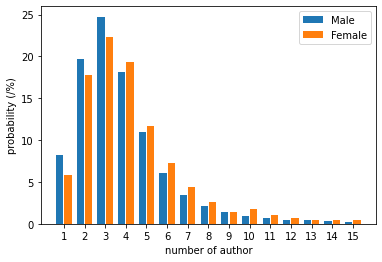

In [ ]:
# female = [5, 10, 15, 20, 25]
# male = [15, 20, 30, 16, 13]
fig = plt.figure()
x_axis = np.arange(len(x))

# Multi bar Chart

plt.bar(x_axis -0.2, male_num, width=0.35, label = 'Male')
plt.bar(x_axis +0.2, female_num, width=0.35, label = 'Female')

# Xticks

plt.xticks(x_axis, x)
plt.xlabel("number of author")
plt.ylabel("probability (/%)")
# Add legend

plt.legend()

# Display

plt.show()
# fig.savefig("coauthorship_distribution.pdf", format="pdf", dpi=1200)
fig.savefig('coauthorship_distribution.pdf', dpi=600, bbox_inches='tight')

In [ ]:
female_dist = female_df["num_of_authors"].values
female_dist = female_dist[~np.isnan(female_dist)]
len(female_dist)

6294

In [ ]:
male_dist = male_df["num_of_authors"].values
male_dist = male_dist[~np.isnan(male_dist)]
len(male_dist)

22294

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew

print(kurtosis(female_dist))
print(kurtosis(male_dist))
print(skew(female_dist))
print(skew(male_dist))

27.42201420391656
33.45408097037625
4.2203543615052626
4.4218861560682425


In [ ]:
import json
with open("/content/drive/MyDrive/AI_Scholar_gender/gs_papers.jsonl") as f:
  scholars = [json.loads(line) for line in f if line.strip()]
df = pd.DataFrame(scholars)

In [ ]:
df.iloc[1][0]

'https://scholar.google.com/citations?view_op=view_citation&hl=en&user=uj3P_0EAAAAJ&cstart=20&pagesize=80&citation_for_view=uj3P_0EAAAAJ:L8Ckcad2t8MC'

In [ ]:
data = np.load("/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/intermediate_data_for_preprocessing/previous_version/paper_83k_info_with_fullnames.npy",allow_pickle=True)
print(data[1])

{'gs_id': '13633406419057296907', 'url': 'https://scholar.google.com/citations?view_op=view_citation&hl=en&user=phHWCVsAAAAJ&cstart=20&pagesize=80&citation_for_view=phHWCVsAAAAJ:_Ybze24A_UAC', 'paper_link': 'https://www3.med.unipmn.it/dispense_bm/2009-2010/PRAT/papers_cart-bone/ESC%20x%20skel%20TE%20-rev-JTERM%201001.pdf', 'Authors': 'Jojanneke M Jukes, Clemens A Van Blitterswijk, Jan De Boer', 'Publication date': '2010/3', 'Source': 'Journal of tissue engineering and regenerative medicine', 'Volume': '4', 'Issue': '3', 'Pages': '165-180', 'Publisher': 'John Wiley & Sons, Ltd.', 'Description': '  Various cell types have been investigated as candidate cell sources for cartilage and bone tissue engineering. In this review, we focused on chondrogenic and osteogenic differentiation of mouse and human embryonic stem cells (ESCs) and their potential in cartilage and bone tissue engineering. A decade ago, mouse ESCs were first used as a model to study cartilage and bone development and essent

In [ ]:
num = 0
for index, row in df.iterrows():
  genders = row["genders"]
  genders = genders.replace('[','')
  genders = genders.replace(']','')
  genders = genders.split(",")
  if genders[0].strip() == "'M'" and genders[-1].strip() == "'M'":
    num += 1

print(num)


12430


In [ ]:
!pip install efficiency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
class Name2Gender:
    def __init__(self):
        self.full_name2gender = self._load_full_name_gender()
        self.first_name2gender = self._load_first_name_gender()

    def _load_first_name_gender(self):
        # 100711 lines
        from collections import defaultdict
        df = pd.read_csv("/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/intermediate_data_for_preprocessing/gender_files/firstname_gender.csv")
        first_name_n_gender = df.to_dict(orient='records')
        first_name2gender = {dic['name']: dic['gender'] for dic in first_name_n_gender}
        return first_name2gender

    def _load_full_name_gender(self):
        def _file2full_name(file):
            from efficiency.log import fread
            full_names = fread(file, delete_empty=True, if_strip=True)
            # full_names = U.read_file(file)
            full_names = [' '.join(i.split(', ', 1)[::-1]).lower() for i in full_names]
            return full_names

        gender2file = {'M': '/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/intermediate_data_for_preprocessing/gender_files/acl-male.txt',
                       'F': '/content/drive/MyDrive/AI_Scholar_gender/AI_scholar_data/intermediate_data_for_preprocessing/gender_files/acl-female.txt',
                       }
        full_name2gender = {}
        for gender, file in gender2file.items():
            full_names = _file2full_name(file)
            full_name2gender.update({i: gender for i in full_names})
        return full_name2gender

    def lookup_gender(self, full_name):
        gender = self.full_name2gender.get(full_name.lower(), '-')
        if gender == '-':
            first_name = full_name.rsplit(' ', 1)[0].lower()
            gender = self.first_name2gender.get(first_name, '-')
        return gender

gender_table = Name2Gender()

In [ ]:
num = 0
for each in data:
  try:
    names = each["Authors"].split(',')
    male = 0
    female = 0
    for name in names:
      if gender_table.lookup_gender(name.strip()) == 'M':
        male += 1
      elif gender_table.lookup_gender(name.strip()) == 'F':
        female += 1
    if male / (female + male) > 0.5 and gender_table.lookup_gender(names[-1].strip()) == 'M':
      num += 1
    # if gender_table.lookup_gender(names[0].strip()) == 'M' and gender_table.lookup_gender(names[-1].strip()) == 'M':
    #   num += 1
  except:
    continue
  # break
print(num)

28178


In [ ]:
paper_dict = []
for index, row in df.iterrows():
  genders = row["genders"]
  genders = genders.replace('[','')
  genders = genders.replace(']','')
  genders = genders.split(",")
  first_male = False
  first_female = False
  last_male = False
  last_female = False
  female = 0
  male = 0
  male_dominate = False
  female_dominate = False
  if genders[0].strip() == "'M'":
    first_male = True
  elif genders[0].strip() == "'F'":
    first_female = True
  if genders[-1].strip() == "'M'":
    last_male = True
  elif genders[-1].strip() == "'F'":
    last_female = True
  for gender in genders:
    if gender.strip() == "'F'":
      female += 1
    elif gender.strip() == "'M'":
      male += 1
  if female + male != 0 and male / (female + male) > 0.5:
    male_dominate = True
  elif female + male != 0 and female / (female + male) > 0.5:
    female_dominate = True
  # if ((first_male or first_female) and (last_male or last_female) and (male_dominate or female_dominate)):
  current = {'first_male': first_male, 'first_female': first_female, 'last_male': last_male, 'last_female': last_female, 'male_dominate': male_dominate, 'female_dominate': female_dominate}
  paper_dict.append(current)

In [ ]:
paper_df = pd.DataFrame(paper_dict)

In [ ]:
len(paper_df)

91790

In [ ]:
id2gender = {}
for each in data:
  id = each["gs_id"]
  try:
    names = each["Authors"].split(',')
  except:
    names = []
  genders = [gender_table.lookup_gender(name.strip()) for name in names]
  print(id)
  print(names)
  print(genders)
  break
  id2gender[id] = genders 

10251033406930934735
['Peter Clark', ' Phil Harrison', ' Niranjan Balasubramanian']
['M', 'M', 'M']


In [ ]:
author_info = df.iloc[0]["authors"]
author_info
author_name = []
for author in author_info:
  author_name.append(author["name"])
gender_info = [gender_table.lookup_gender(name) for name in author_name]

"[{'authorId': '49564745', 'name': 'K. S. Lee'}, {'authorId': '4929876', 'name': 'J. S. Kim'}, {'authorId': '153897458', 'name': 'C. S. Lee'}, {'authorId': '91630015', 'name': 'C. Yoon'}, {'authorId': '2107766606', 'name': 'J. W. Choi'}]"

In [ ]:
temp = paper_df[(paper_df["female_dominate"])]
# paper_df.loc[(paper_df['first_female'] == 'Rack') & (dobj['Marks'] == 100)]
temp

,first_male,first_female,last_male,last_female,male_dominate,female_dominate
12,False,False,False,False,False,True
33,False,False,False,True,False,True
79,False,True,False,True,False,True
85,False,False,False,False,False,True
88,False,False,False,True,False,True
...,...,...,...,...,...,...
91731,False,True,False,False,False,True
91734,False,False,False,True,False,True
91737,False,True,False,True,False,True
91753,False,True,False,True,False,True


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

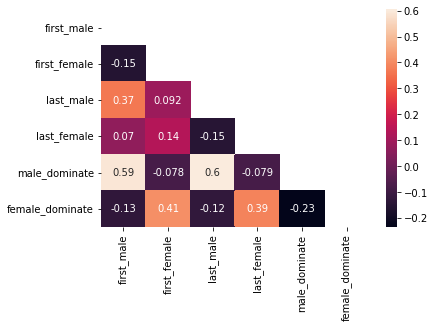

In [ ]:
matrix = np.triu(paper_df.corr())
sns.heatmap(paper_df.corr(), annot=True, mask=matrix);
plt.savefig('heatmap.pdf', dpi=600, bbox_inches='tight')